# ANKAN ROY

## MSML602

## Project 2

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import linregress

In [2]:
db_filepath = "lahman2014.sqlite"
conn = sqlite3.connect(db_filepath)

## Part 1: Wrangling

#### Problem 1

In [3]:
# Get winning percentage (W / G * 100)
query = "SELECT yearID, teamID, franchID, W as wins, L as losses, G as games_played, (W * 1.0 / G * 100) AS win_percentage FROM Teams"

win_p_table = pd.read_sql(query, conn)
win_p_table.head(5)

,yearID,teamID,franchID,wins,losses,games_played,win_percentage
0,1871,BS1,BNA,20,10,31,64.516129
1,1871,CH1,CNA,19,9,28,67.857143
2,1871,CL1,CFC,10,19,29,34.482759
3,1871,FW1,KEK,7,12,19,36.842105
4,1871,NY2,NNA,16,17,33,48.484848


In [4]:
# Get payroll per team
query = "SELECT yearID, teamID, SUM(Salary) AS total_salary FROM Salaries GROUP BY teamID, yearID"

total_sal_table = pd.read_sql(query, conn)
total_sal_table.head()

,yearID,teamID,total_salary
0,1985,ATL,14807000.0
1,1985,BAL,11560712.0
2,1985,BOS,10897560.0
3,1985,CAL,14427894.0
4,1985,CHA,9846178.0


In [5]:
# Join both tables
table = win_p_table.merge(total_sal_table, how="inner", left_on=["yearID", "teamID"], right_on=["yearID", "teamID"])
table.dropna(inplace=True)
table.head()

,yearID,teamID,franchID,wins,losses,games_played,win_percentage,total_salary
0,1985,BAL,BAL,83,78,161,51.552795,11560712.0
1,1985,BOS,BOS,81,81,163,49.693252,10897560.0
2,1985,CAL,ANA,90,72,162,55.555556,14427894.0
3,1985,CHA,CHW,85,77,163,52.147239,9846178.0
4,1985,CLE,CLE,60,102,162,37.037037,6551666.0


In this problem, any missing data was handled primarily through the use of an INNER JOIN, where only the rows present in both the Teams and Salaries tables were included. In other words, if a team had no salary data for a given year, or if performance data was missing, that row was excluded from the final result. Additionally, dropna() was applied to remove any remaining rows with missing values, in case there were any, ensuring that the final dataset contained only complete data.

## Part 2: Exploratory Data Analysis
### Payroll Distribution
#### Problem 2

In [6]:
table_vis = table[(table["yearID"] >= 1990) & (table["yearID"] <= 2014)]

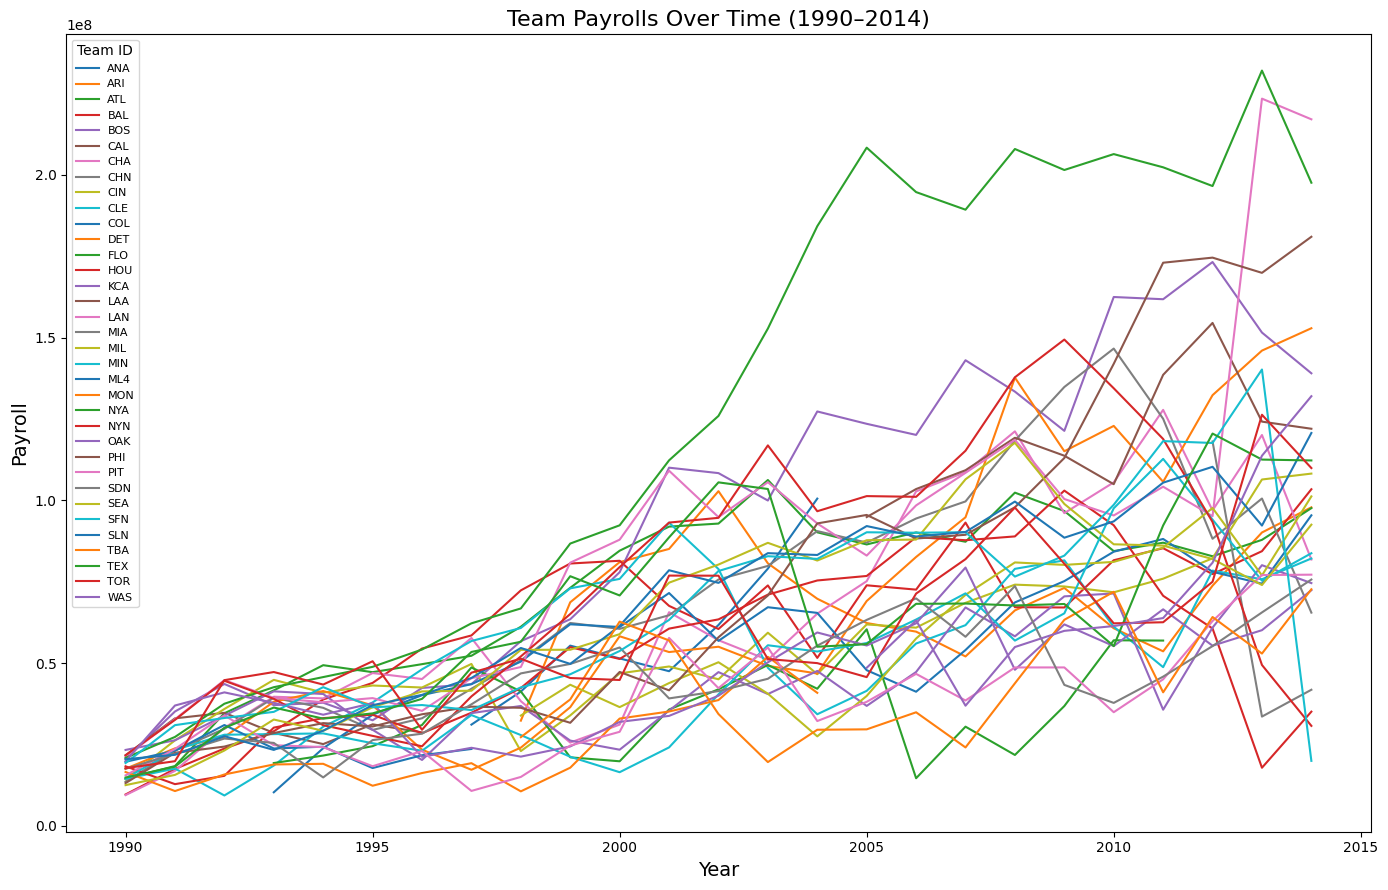

In [7]:
import matplotlib.pyplot as plt
import plotly.express as px

plt.figure(figsize=(14, 9))

for team, df_team in table_vis.groupby("teamID"):
    plt.plot(
        df_team["yearID"],
        df_team["total_salary"],
        label=team,
        linewidth=1.5
    )

plt.title("Team Payrolls Over Time (1990–2014)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Payroll", fontsize=14)
plt.legend(title="Team ID", fontsize=8)
plt.tight_layout()
plt.show()

Team Payrolls Over Time (1990-2014) is a single plot with a line for each team. It shows rge payroll on the y-axis and year (1990-2014) on the x-axis.

#### Question 1

From 1990 to 2014, MLB team payrolls generally increased steadily across all teams, with a noticeable widening in the distribution. While all teams generally spent more over time, the gap between high and low earning teams got wider. The overall trend suggests both rising central tendency (mean/median payroll) and greater spread (variance) in team spending.

#### Problem 3

In [8]:
grouped_payroll = table_vis.groupby("yearID")["total_salary"].mean().reset_index()

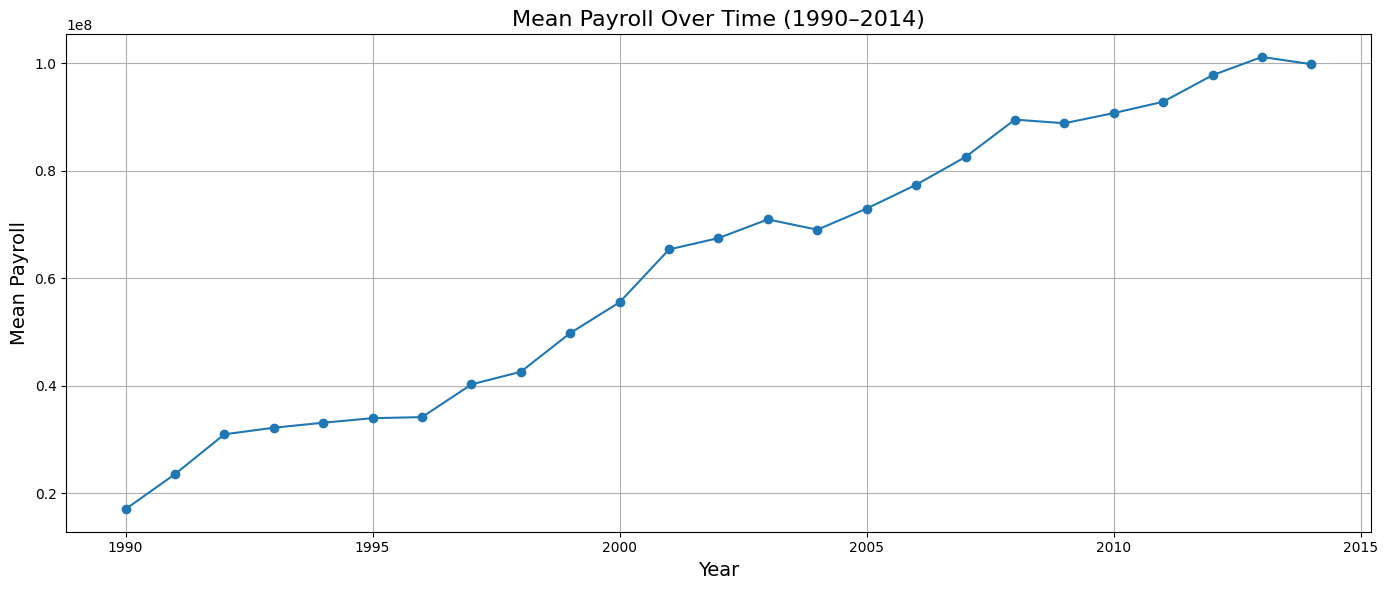

In [9]:
plt.figure(figsize=(14, 6))

plt.plot(
    grouped_payroll["yearID"],
    grouped_payroll["total_salary"],
    marker='o',
    linestyle='-',
    color='tab:blue'
)

plt.title("Mean Payroll Over Time (1990–2014)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Mean Payroll", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

In Question 1, the trend of mean payroll generally increasing over time was discussed. Mean Payroll Over Time (1990-2014) is a line graph which shows the average payroll increasing across all teams over the years from 1990 to 2014.

### Correlation between payroll and winning percentage
#### Problem 4

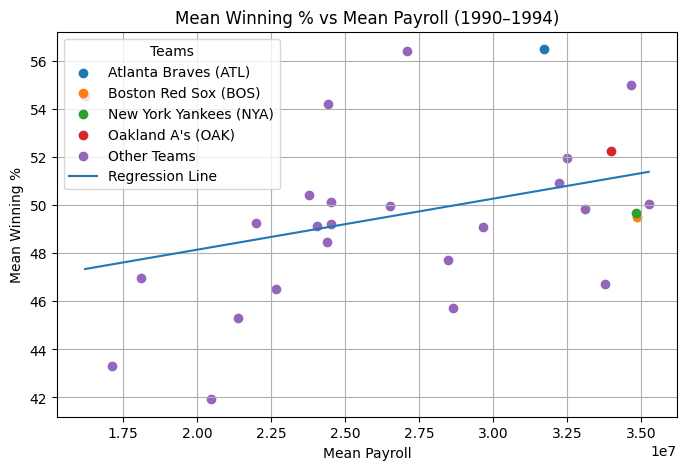

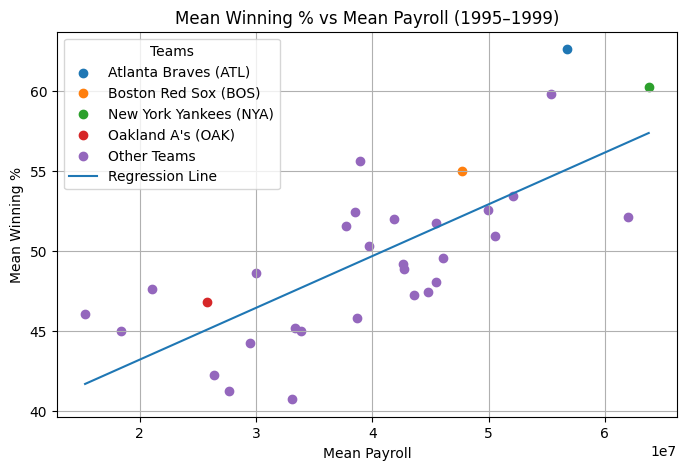

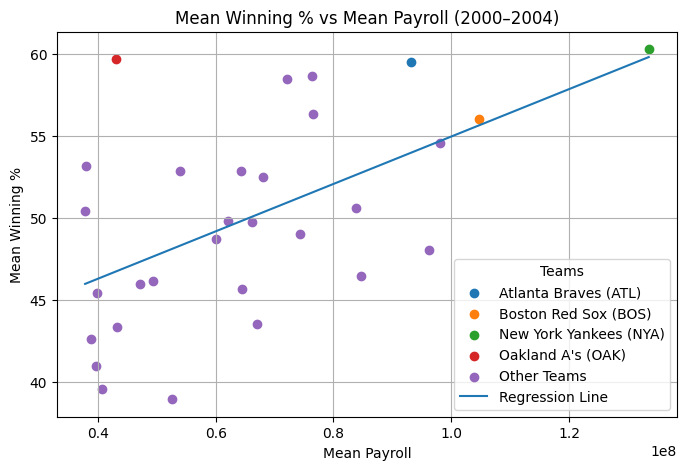

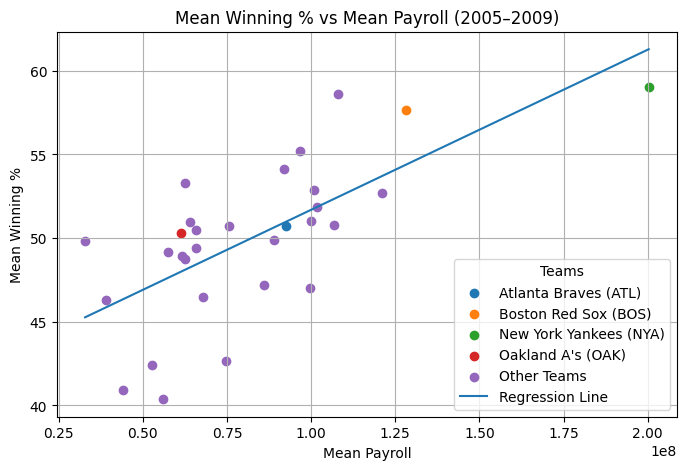

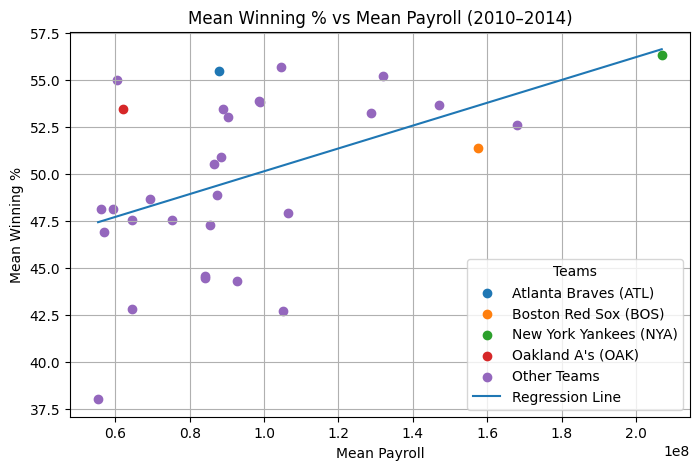

In [10]:
# Split into five time periods
bins = np.floor(np.linspace(1990, 2014, 6))
labels = ["1990–1994", "1995–1999", "2000–2004", "2005–2009", "2010–2014"]

# Create new table that has each team's mean payroll brouped by each time period
table_vis.reset_index(inplace=True)
table_vis = table_vis.copy()
table_vis["period"] = pd.cut(
    table_vis["yearID"],
    bins=bins, labels=labels, include_lowest=True, right=True
)
grouped = table_vis.groupby(["period", "teamID"], observed=False).agg(
    mean_salary=("total_salary", "mean"),
    mean_win_pct=("win_percentage", "mean")
).dropna().reset_index()

# Teams to analyze
team_map = {
    "OAK": "Oakland A's (OAK)",
    "NYA": "New York Yankees (NYA)",
    "BOS": "Boston Red Sox (BOS)",
    "ATL": "Atlanta Braves (ATL)"
}

for period in labels:
    df_period = grouped[grouped["period"] == period].copy()
    df_period.loc[:, "Teams"] = df_period["teamID"].map(team_map).fillna("Other Teams")

    # Regression
    x = df_period["mean_salary"].to_numpy()
    y = df_period["mean_win_pct"].to_numpy()
    res = linregress(x, y)
    r2 = res.rvalue**2

    # Generate scatter plot
    fig, ax = plt.subplots(figsize=(8, 5))
    for team_name, df_team in df_period.groupby("Teams"):
        ax.scatter(
            df_team["mean_salary"],
            df_team["mean_win_pct"],
            label=team_name,
        )

    # Regression line
    x_line = np.linspace(x.min(), x.max())
    y_line = res.intercept + res.slope * x_line

    # Labels
    ax.plot(x_line, y_line, label=f"Regression Line")
    ax.set_title(f"Mean Winning % vs Mean Payroll ({period})")
    ax.set_xlabel("Mean Payroll")
    ax.set_ylabel("Mean Winning %")
    ax.grid(True)
    ax.legend(title="Teams")

    plt.show()

There are five scatter plots containing all the teams, one each for a four-year period (1990-1994, 1995-1999, 2000-2004, 2005-2009, 2010-2014). Each plot shows the Mean Winning Percentage vs. Mean Payroll. Specific teams, namely Oakland A's (OAK), New York Yankees (NYA), Boston Red Sox (BOS), and Atlanta Braves (ATL) have been highlighted for comparison.

#### Question 2

Throughout all time periods, the plots show that teams with a higher mean payroll correlate to a higher average mean winning percentage. As for the Oakland A's, however, it is generally mixed. In the time period 1990-1994, they had a mean payroll of around $34M and a 52% mean win rate. However, in the time period 2000-2004 after that, they had a significantly lower Mean Payroll of around $43M, but a higher win rate at 59%. This shows that mean payroll is not a significant feature in the Oakland A's win rate, and that there are other features at play. Teams like NYA, BOS, or ATL show that spending higher on players does result in onsistently high win rates, but OAK seems to be an outlier, suggesting that despite having lower spending, they achieve competitive win rates, and this indicates greater spending efficiency compared to other teams.

## Part 3: Data transformations
### Standardizing across years

#### Problem 5

In [11]:
grouped_salaries = table_vis.groupby("yearID", observed="False")["total_salary"].mean().reset_index()
grouped_std = table_vis.groupby("yearID", observed="False")["total_salary"].std().reset_index()
grouped_agg = grouped_std.merge(grouped_salaries, how="inner", left_on=["yearID"], right_on=["yearID"])

grouped_agg.rename(columns={"total_salary_x": "mean_std_for_period", "total_salary_y": "mean_salary_for_period"}, inplace=True)

standardized_table = table_vis.merge(grouped_agg, how="inner", left_on=["yearID"], right_on=["yearID"])
standardized_table.head()

,index,yearID,teamID,franchID,wins,losses,games_played,win_percentage,total_salary,period,mean_std_for_period,mean_salary_for_period
0,130,1990,BAL,BAL,76,85,161,47.204969,9680084.0,1990–1994,3.771834e+06,1.707235e+07
1,131,1990,BOS,BOS,88,74,162,54.320988,20558333.0,1990–1994,3.771834e+06,1.707235e+07
2,132,1990,CAL,ANA,80,82,162,49.382716,21720000.0,1990–1994,3.771834e+06,1.707235e+07
3,133,1990,CHA,CHW,94,68,162,58.024691,9491500.0,1990–1994,3.771834e+06,1.707235e+07
4,134,1990,CLE,CLE,77,85,162,47.530864,14487000.0,1990–1994,3.771834e+06,1.707235e+07


In [12]:
mean_payroll = table_vis["total_salary"].mean()
payrolls = []

for i, row in standardized_table.iterrows():
    payroll_ij = standardized_table["total_salary"].iloc[i]
    payroll_j = standardized_table["mean_salary_for_period"].iloc[i]
    std_j = standardized_table["mean_std_for_period"].iloc[i]

    standardized_payroll = (payroll_ij - payroll_j) / std_j  
    payrolls.append(standardized_payroll)

standardized_table["standardized_payroll"] = payrolls
standardized_table["standardized_payroll"].head()

0   -1.959861
1    0.924213
2    1.232198
3   -2.009859
4   -0.685437
Name: standardized_payroll, dtype: float64

#### Problem 6

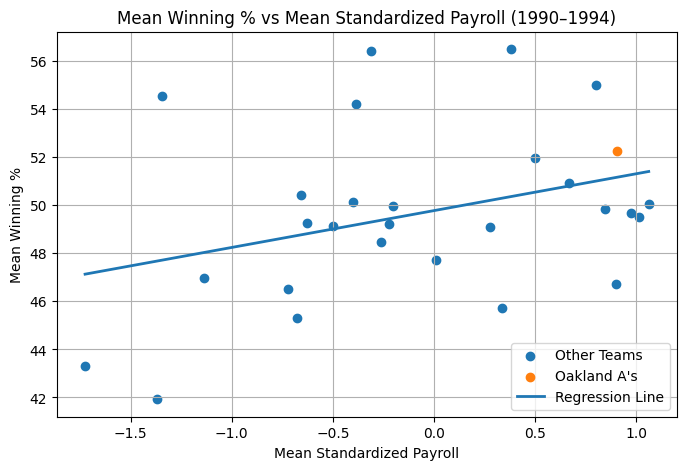

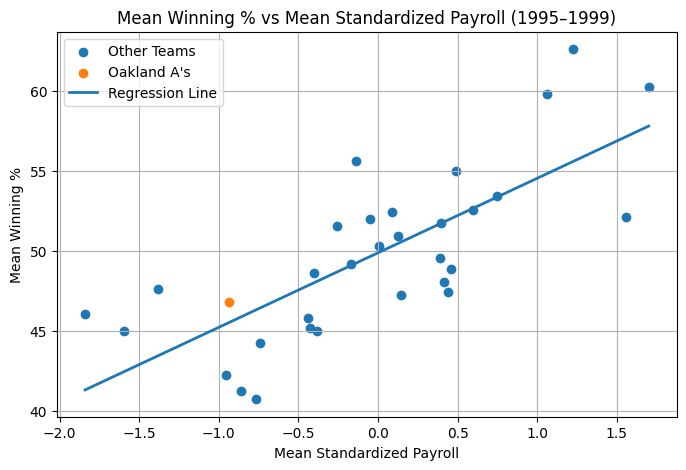

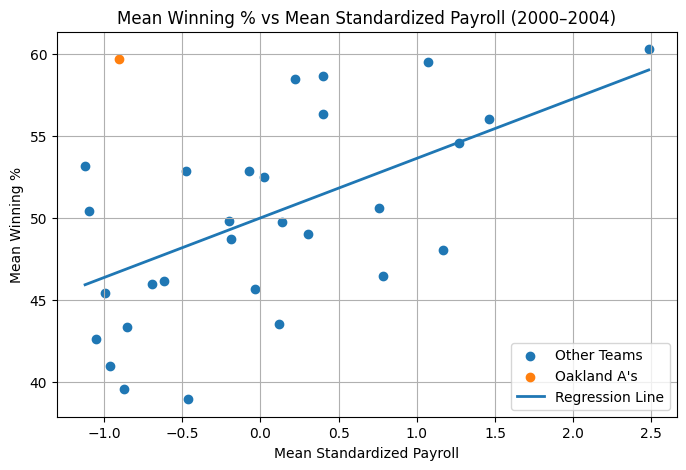

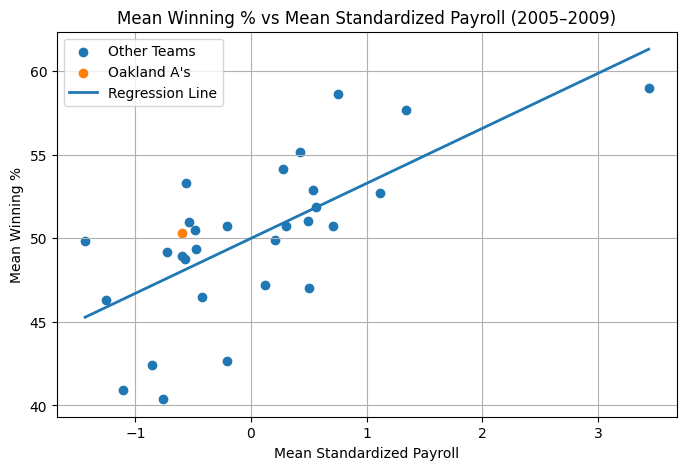

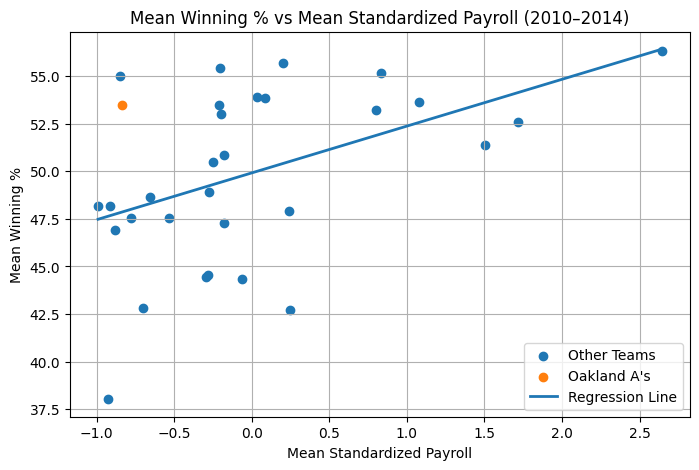

In [13]:
# Time periods
bins = np.floor(np.linspace(1990, 2014, 6))
labels = ["1990–1994", "1995–1999", "2000–2004", "2005–2009", "2010–2014"]

# Create a new table that has each team's mean standardized payroll grouped by each time period
standardized_table = standardized_table.copy()
standardized_table = standardized_table.assign(
    period=pd.cut(
        standardized_table["yearID"],
        bins=bins, labels=labels, include_lowest=True, right=True
    )
)
grouped = standardized_table.groupby(["period", "teamID"], observed=True).agg(
    standardized_payroll=("standardized_payroll", "mean"),
    mean_win_pct=("win_percentage", "mean")
).dropna().reset_index()

for period in labels:
    df_period = grouped[grouped["period"] == period].copy()
    df_period.loc[:, "Teams"] = np.where(df_period["teamID"] == "OAK", "Oakland A's", "Other Teams")

    # Regression
    x = df_period["standardized_payroll"].to_numpy()
    y = df_period["mean_win_pct"].to_numpy()
    res = linregress(x, y)
    r2 = res.rvalue**2

    # Generate plot
    fig, ax = plt.subplots(figsize=(8, 5))
    df_others = df_period[df_period["Teams"] == "Other Teams"]
    df_oak = df_period[df_period["Teams"] == "Oakland A's"]

    # Generate scatter plot
    ax.scatter(df_others["standardized_payroll"], df_others["mean_win_pct"], label="Other Teams")
    ax.scatter(df_oak["standardized_payroll"], df_oak["mean_win_pct"], label="Oakland A's")

    # Regression Line
    x_line = np.linspace(x.min(), x.max())
    y_line = res.intercept + res.slope * x_line

    # Labels
    ax.plot(x_line, y_line, linewidth=2, label=f"Regression Line")
    ax.set_title(f"Mean Winning % vs Mean Standardized Payroll ({period})")
    ax.set_xlabel("Mean Standardized Payroll")
    ax.set_ylabel("Mean Winning %")
    ax.grid(True)
    ax.legend()

    plt.show()


Comparing payrolls across years is inefficient, so I created a new variable in the dataset that standardizes payroll conditioned on year. For team *i* in year *j*,
$
standardized\_payroll_{ij} = \frac{payroll_{ij} - \overline{payroll}_{j}}{s_j}
$
for team *i* in year *j*, where $\overline{payroll}_{j}$ is the average payroll for year *j*, and $s_j$ is the standard deviation of payroll for year *j*. With this new standardized payroll variable, five new plots were created showing the mean winning percentage of each team vs. mean standardized payroll for those respective teams.

#### Question 3

The plots from Problem 4 and Problem 6 display the same underlying relationship between payroll and winning percentage, but they differ in how payroll is represented. In Problem 4, payroll is shown in its original dollar scale, while in Problem 6, the payroll variable has been standardized within each year. By doing this transformation, the shape and direction of the relationship between win rate and payroll remain the same, but the x-axis now allows for better comparison across time periods since the influence of changing salary levels is removed. Teams with negative standardized payroll values generally spent below the league average for that period, and those with positive values spent above it.

#### Problem 7

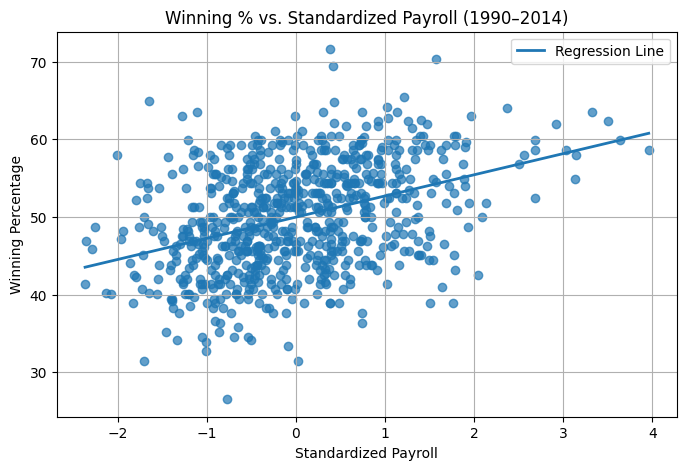

In [14]:
standardized_table = standardized_table.copy()
year_mean = standardized_table.groupby("yearID")["total_salary"].transform("mean")
year_std  = standardized_table.groupby("yearID")["total_salary"].transform("std")
standardized_table.loc[:, "standardized_payroll"] = (standardized_table["total_salary"] - year_mean) / year_std
x = standardized_table["standardized_payroll"].to_numpy()
y = standardized_table["win_percentage"].to_numpy()
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

# Regression
res = linregress(x, y)
slope = res.slope
intercept = res.intercept
r2 = res.rvalue**2

# Generate plot
fig, ax = plt.subplots(figsize=(8, 5))

# Generate scatter plot
ax.scatter(standardized_table.loc[mask, "standardized_payroll"], standardized_table.loc[mask, "win_percentage"], alpha=0.7)

# Regression line
xs = np.linspace(x.min(), x.max())
ys = intercept + slope * xs

# Labels
ax.plot(xs, ys, linewidth=2, label=f"Regression Line")
ax.set_title("Winning % vs. Standardized Payroll (1990–2014)")
ax.set_xlabel("Standardized Payroll")
ax.set_ylabel("Winning Percentage")
ax.grid(True)
ax.legend()

plt.show()

After standardizing payroll, we create a single scatter plot of winning percentage vs. standardized payroll and add a regression line to show their relationship. The regression line gives an equation like:
$
expected\_win\_pct_{ij} = 50 + 2.5 * standardized\_payroll_{ij}
$.

#### Problem 8

In [15]:
standardized_table["expected_win_pct"] = intercept + slope * standardized_table["standardized_payroll"]
standardized_table["spending_efficiency"] = standardized_table["win_percentage"] - standardized_table["expected_win_pct"]

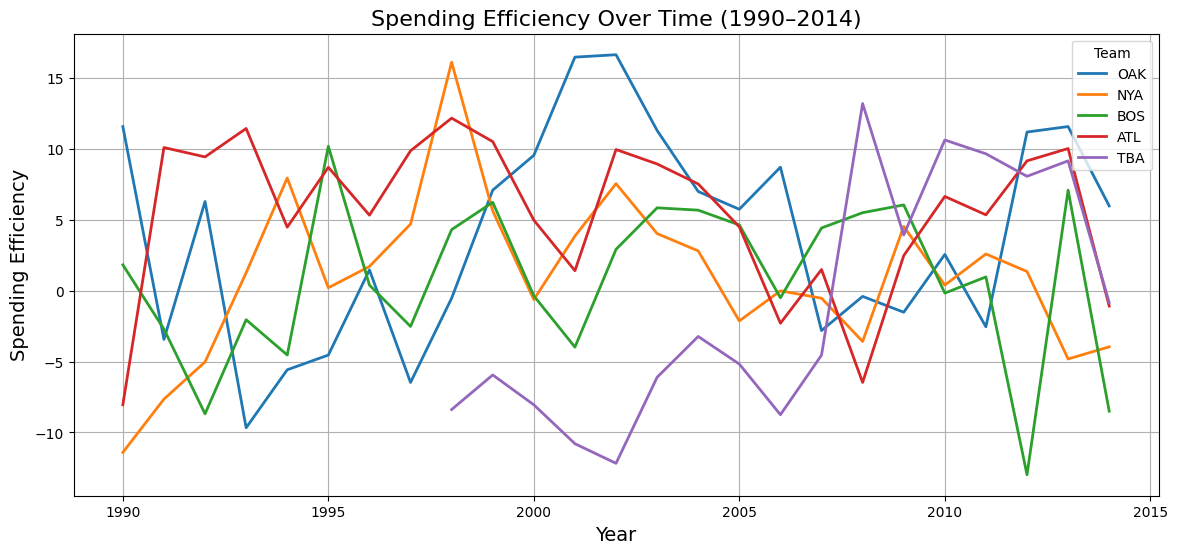

In [16]:
teams = ["OAK", "NYA", "BOS", "ATL", "TBA"]
plot_df = standardized_table[standardized_table["teamID"].isin(teams)].sort_values(["teamID", "yearID"])

plot_df = plot_df.copy()

plt.figure(figsize=(14, 6))

for team in teams:
    df_t = plot_df[plot_df["teamID"] == team]
    if df_t.empty:
        continue
    plt.plot(
        df_t["yearID"],
        df_t["spending_efficiency"],
        label=team,
        linewidth=2,
    )

plt.title("Spending Efficiency Over Time (1990–2014)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Spending Efficiency", fontsize=14)
plt.legend(title="Team", fontsize=10)
plt.grid(True)

plt.show()

Using the expected win percentage, we can calculate each team’s expected winning percentage and compare it to their actual performance to measure spending efficiency as:
$
spending\_efficiency_{ij} = actual\_win\_pct_{ij} - expected\_win\_pct_{ij}
$.

#### Question 4

This plot confirms what was observed in Question 2 and 3, that Oakland A's has a generally higher spending efficiency, especially after the year 2000. Despite having lower payrolls for their players, they have a competitive win rate, contributing to a higher spending efficiency. At the end of 2014, the Oakland A's has the highest spending efficiency among these teams.

## How My Code Works

Part 1:
I write a SQL query to get each team’s wins, losses, and total games from the database. Afterwards, I calculate the win percentage by dividing wins by games played and multiplying by 100. This data is then loaded into a pandas DataFrame called win_p_table. I then combine this performance data with the total salary data (total_sal_table) using a merge. Any rows with missing values are removed to keep the dataset clean. The updated table now contains both team performance and payroll information for each season.

Part 2:
I first filter the dataset to only include seasons from 1990 to 2014 for analysis. Then, I create a line chart that shows how each team’s payroll changes over time to spot trends and spending differences, and also calculate and plot the mean payroll per year. This timeline is divided into five-year periods to analyze spending and performance in smaller chunks. For each period, I calculate the mean payroll and mean win percentage for every team. Scatter plots with regression lines are also created showing how payroll relates to winning.

Part 3:
I first compute the mean and standard deviation of payroll for each year, then merge these yearly stats back onto each team season.Afterwards, I standardize payroll within each year by subtracting the yearly mean and dividing by the yearly standard deviation, for which scatter plots are created. I then recompute standardized payroll using a vectorized approach for the whole 1990–2014 sample to fit a global regression of win percentage on standardized payroll across all seasons. The global model is used to compute an expected win percentage for every team season. Finally, I calculate spending efficiency as actual win percentage minus expected win percentage, and plot the spending efficiency of certain teams over time.